## Loading Dataset

In [ ]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse

from tqdm.notebook import tqdm
import typing as tp
import numpy.typing as ntp

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
import json
from pathlib import Path

def load_multiwoz(split, path='/content/drive/MyDrive/ML&Stats labs/innoprac_deeppavlov/multiwoz/data/MultiWOZ_2.2'):
    data_dir = Path(path) / split
    data = []
    data_parts = list(data_dir.iterdir())
    for data_part in tqdm(data_parts):
        with data_part.open() as f:
            data.extend(json.load(f))
    return data

In [ ]:
from itertools import accumulate

class Utterance:
    def __init__(self, utterance: str, speaker: str, turn_id: str, **meta: tp.Any):
        self.utterance = utterance
        self.speaker = speaker
        self.turn_id = turn_id
        self.meta = meta
    
    def __str__(self) -> str:
        return self.utterance
    
    def __repr__(self) -> str:
        return f"[{self.turn_id:>2}] {self.speaker:>8}: \"{self.utterance}\""
    
    @classmethod
    def from_multiwoz_v22(cls, utterance: tp.Dict[str, tp.Any]) -> 'Utterance':
        return cls(**utterance)
    

class Dialogue:
    def __init__(self, utterances: tp.List[Utterance], dialogue_id: str, **meta: tp.Any):
        self.utterances = utterances
        self.dialogue_id = dialogue_id
        self.meta = meta
    
    def __len__(self) -> int:
        return len(self.utterances)
    
    def __str__(self) -> str:
        return "\n".join(str(utt) for utt in self.utterances)
    
    def __repr__(self) -> str:
        return f"[{self.dialogue_id}]\n" + '\n'.join(repr(utt) for utt in self.utterances)
    
    def __getitem__(self, i) -> Utterance:
        return self.utterances[i]
    
    def __iter__(self) -> tp.Iterator[Utterance]:
        return iter(self.utterances)
        
    
    @classmethod
    def from_multiwoz_v22(cls, dialogue: tp.Dict[str, tp.Any]) -> 'Dialogue':
        utterances = [Utterance.from_multiwoz_v22(utt) for utt in dialogue['turns']]
        dialogue_id = dialogue['dialogue_id']
        meta = {key: val for key, val in dialogue.items() if key not in ['turns', 'dialogue_id']}
        return cls(utterances=utterances, dialogue_id=dialogue_id, **meta)


class DialogueDataset(list):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.utterances = [utt.utterance for dialog in self for utt in dialog]
        
        self._dialogue_start = list(accumulate([0] + [len(dialogue) for dialogue in self]))
        
        self._utt_dialogue_id = [0] * len(self.utterances)
        self._utt_id = [0] * len(self.utterances)
        for d_start in self._dialogue_start[1:-1]:
            self._utt_dialogue_id[d_start] = 1
        current_utt_id = 0
        for i in range(len(self._utt_id)):
            if self._utt_dialogue_id[i] == 1:
                current_utt_id = 0
            self._utt_id[i] = current_utt_id
            current_utt_id += 1
        self._utt_dialogue_id = list(accumulate(self._utt_dialogue_id))
        
        self._dial_id_mapping = {dialogue.dialogue_id: i 
                                for i, dialogue in enumerate(self)}
    
    def get_dialogue_by_idx(self, idx: int) -> Dialogue:
        udi = self._utt_dialogue_id[idx]
        return self[udi]
    
    def get_utterance_by_idx(self, idx: int) -> Utterance:
        udi = self._utt_dialogue_id[idx]
        ui = self._utt_id[idx]
        return self[udi][ui]
    
    def get_dialog_start_idx(self, dialogue: 'Dialog') -> int:
        dialogue_idx = self._dial_id_mapping[dialogue.dialogue_id]
        d_start = self._dialogue_start[dialogue_idx]
        return d_start
    
    @classmethod
    def from_miltiwoz_v22(cls, multiwoz_v22: tp.List[tp.Dict[str, tp.Any]]) -> 'DialogueDataset':
        dialogues = [Dialogue.from_multiwoz_v22(dialog) for dialog in multiwoz_v22]
        return cls(dialogues)

class Subset(DialogueDataset):
    def __init__(self, dialogues: DialogueDataset, subset: tp.Iterable):
        subset_dialogues = [dialogues[idx] for idx in subset]
        super().__init__(subset_dialogues)

In [ ]:
test = DialogueDataset.from_miltiwoz_v22(load_multiwoz('test'))
val = DialogueDataset.from_miltiwoz_v22(load_multiwoz('dev'))
train = DialogueDataset.from_miltiwoz_v22(load_multiwoz('train'))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

In [ ]:
# Returns lists of phrases in Dialogue as a list of strings
def dialogue_as_list(d):
  lst = []
  ids = []
  speakers = []
  for phr in d:
    lst.append(str(phr))
    ids.append(phr.turn_id)
    speakers.append(phr.speaker)
  return lst, ids

In [ ]:
d=""
print(len(val))
for dialog in val:
  print(dialog)
  d=dialog
  break

1000
I'm looking for a local place to dine in the centre that serves chinese food.
I have restaurants matching your criteria in all price ranges. Do you have a preference on price?
I need the address, postcode and the price range.
Ok how about Charlie Chan, located at Regent Street City Centre. Postcode is cb21db with a cheap price. Can I help you further today?
I also need a train. The train should leave after 16:15 and should leave on sunday.
Can I have more information for the train you're needing? Where are you departing from and arriving to?
I am leaving from Cambridge and going to Norwich.
I have train TR1840 leaving at 16:36 is that okay?
book for 5 people and get me the reference number
You're all set. Reference number is NJB87PAP . Is there anything else I can help you with today?
No, this is all I will need. Thank you.
Thank for calling us today. I hope you have a good trip.


In [ ]:
print(len(d))
print(d[0])
print(d[11])
type(d[0])

12
I'm looking for a local place to dine in the centre that serves chinese food.
Thank for calling us today. I hope you have a good trip.


__main__.Utterance

## Sentiment analysis

### Bertweet-sentiment-analysis

https://github.com/pysentimiento/pysentimiento 

In [ ]:
!pip install pysentimiento

     |████████████████████████████████| 311 kB 30.4 MB/s 
     |████████████████████████████████| 3.8 MB 69.4 MB/s 
     |████████████████████████████████| 174 kB 73.7 MB/s 
     |████████████████████████████████| 1.1 MB 59.2 MB/s 
     |████████████████████████████████| 134 kB 76.1 MB/s 
     |████████████████████████████████| 67 kB 7.6 MB/s 
     |████████████████████████████████| 212 kB 70.8 MB/s 
     |████████████████████████████████| 6.5 MB 68.8 MB/s 
     |████████████████████████████████| 596 kB 70.8 MB/s 
     |████████████████████████████████| 895 kB 68.4 MB/s 
     |████████████████████████████████| 271 kB 70.6 MB/s 
     |████████████████████████████████| 144 kB 75.4 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
  Created wheel for emoji: filename=emoji-1.6.3-py3-none-any.whl size=170298 sha256=2dc6e22b9fca8727e8671f343865ee2604c81626d7270f4e1223489163621feb
  Stored in directory: /root/.cache/pip/wheels/03/8b/d7/ad579fbef83c287215c0caab60fb0ae0f30c4d7ce5f58

In [ ]:
from pysentimiento import create_analyzer
sentiment_analyzer = create_analyzer(task="sentiment", lang="en")
emotion_analyzer = create_analyzer(task="emotion", lang="en")

Downloading:   0%|          | 0.00/295 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/890 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/515M [00:00<?, ?B/s]

https://huggingface.co/finiteautomata/bertweet-base-emotion-analysis/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpozfdb0ts


Downloading:   0%|          | 0.00/295 [00:00<?, ?B/s]

storing https://huggingface.co/finiteautomata/bertweet-base-emotion-analysis/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/1740697312c59fe96586f476c7765cd6f08516a6102ea96f22ffee64f7553234.c260b44e952f7f2a825aac395f2ebbed4ac9553800d1e320af246e81a548f37c
creating metadata file for /root/.cache/huggingface/transformers/1740697312c59fe96586f476c7765cd6f08516a6102ea96f22ffee64f7553234.c260b44e952f7f2a825aac395f2ebbed4ac9553800d1e320af246e81a548f37c
https://huggingface.co/finiteautomata/bertweet-base-emotion-analysis/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpyjofnzhx


Downloading:   0%|          | 0.00/999 [00:00<?, ?B/s]

storing https://huggingface.co/finiteautomata/bertweet-base-emotion-analysis/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/c246eed05359b1a49c45955b0265b488e35b0cbd2628e3ead7dd54c8815162ee.a2dff24b4e0a884c6d58a09968c5b68e7391e749eb698ad92541818d420fd01b
creating metadata file for /root/.cache/huggingface/transformers/c246eed05359b1a49c45955b0265b488e35b0cbd2628e3ead7dd54c8815162ee.a2dff24b4e0a884c6d58a09968c5b68e7391e749eb698ad92541818d420fd01b
loading configuration file https://huggingface.co/finiteautomata/bertweet-base-emotion-analysis/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/c246eed05359b1a49c45955b0265b488e35b0cbd2628e3ead7dd54c8815162ee.a2dff24b4e0a884c6d58a09968c5b68e7391e749eb698ad92541818d420fd01b
Model config RobertaConfig {
  "_name_or_path": "finiteautomata/bertweet-base-emotion-analysis",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0

Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

storing https://huggingface.co/finiteautomata/bertweet-base-emotion-analysis/resolve/main/vocab.txt in cache at /root/.cache/huggingface/transformers/b7837213513a9f3852dcb04048f70c13cbd0590be030e534734ffd42cbdcf45a.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
creating metadata file for /root/.cache/huggingface/transformers/b7837213513a9f3852dcb04048f70c13cbd0590be030e534734ffd42cbdcf45a.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
https://huggingface.co/finiteautomata/bertweet-base-emotion-analysis/resolve/main/bpe.codes not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpa3dz8llr


Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

storing https://huggingface.co/finiteautomata/bertweet-base-emotion-analysis/resolve/main/bpe.codes in cache at /root/.cache/huggingface/transformers/76e357e2554ebe053d1c4c613506bc2cc19d66ae27fec8218261a7f73c6456b9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
creating metadata file for /root/.cache/huggingface/transformers/76e357e2554ebe053d1c4c613506bc2cc19d66ae27fec8218261a7f73c6456b9.75877d86011e5d5d46614d3a21757b705e9d20ed45a019805d25159b4837b0a4
https://huggingface.co/finiteautomata/bertweet-base-emotion-analysis/resolve/main/added_tokens.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp7qyo79ux


Downloading:   0%|          | 0.00/17.0 [00:00<?, ?B/s]

storing https://huggingface.co/finiteautomata/bertweet-base-emotion-analysis/resolve/main/added_tokens.json in cache at /root/.cache/huggingface/transformers/c4b7522f44ed8adb95e62288c6458da591654f7466e3ce2f9c730bb4087411d2.c1e7052e39d2135302ec27455f6db22e1520e6539942ff60a849c7f83f8ec6dc
creating metadata file for /root/.cache/huggingface/transformers/c4b7522f44ed8adb95e62288c6458da591654f7466e3ce2f9c730bb4087411d2.c1e7052e39d2135302ec27455f6db22e1520e6539942ff60a849c7f83f8ec6dc
https://huggingface.co/finiteautomata/bertweet-base-emotion-analysis/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpgqr3pysh


Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

storing https://huggingface.co/finiteautomata/bertweet-base-emotion-analysis/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/01581144d9bf96cb9c7d8a77ee93c8b1f1095af5c1204b1b038a8cb0e3247aa8.0dc5b1041f62041ebbd23b1297f2f573769d5c97d8b7c28180ec86b8f6185aa8
creating metadata file for /root/.cache/huggingface/transformers/01581144d9bf96cb9c7d8a77ee93c8b1f1095af5c1204b1b038a8cb0e3247aa8.0dc5b1041f62041ebbd23b1297f2f573769d5c97d8b7c28180ec86b8f6185aa8
loading file https://huggingface.co/finiteautomata/bertweet-base-emotion-analysis/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/b7837213513a9f3852dcb04048f70c13cbd0590be030e534734ffd42cbdcf45a.f8a4dfe5c3c45a26f9df849d732decb191dc0c05ab270799695430332d143982
loading file https://huggingface.co/finiteautomata/bertweet-base-emotion-analysis/resolve/main/bpe.codes from cache at /root/.cache/huggingface/transformers/76e357e2554ebe053d1c4c613506bc2cc19d66ae27fec8218261a7f73c6456b9.75

Downloading:   0%|          | 0.00/515M [00:00<?, ?B/s]

storing https://huggingface.co/finiteautomata/bertweet-base-emotion-analysis/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/61c5894a0aca5ed63159e2ec6a5501db48124c1e6de287b82bc634334f031203.9c3c4c16d0dd174434d42471b9d4670734d982be506a06fc3111c12bee4380c7
creating metadata file for /root/.cache/huggingface/transformers/61c5894a0aca5ed63159e2ec6a5501db48124c1e6de287b82bc634334f031203.9c3c4c16d0dd174434d42471b9d4670734d982be506a06fc3111c12bee4380c7
loading weights file https://huggingface.co/finiteautomata/bertweet-base-emotion-analysis/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/61c5894a0aca5ed63159e2ec6a5501db48124c1e6de287b82bc634334f031203.9c3c4c16d0dd174434d42471b9d4670734d982be506a06fc3111c12bee4380c7
All model checkpoint weights were used when initializing RobertaForSequenceClassification.

All the weights of RobertaForSequenceClassification were initialized from the model checkpoint at finiteautomata/bertweet-

In [ ]:
def label_dialoguedataset(dialogue_dataset):
  data = {}
  data['dialogues'] = []
  for dialogue in tqdm(dialogue_dataset):
    dialog_data = {}
    dialog_data['dialogue_id'] = dialogue.dialogue_id
    dialog_data['turns'] = []

    for uttr in dialogue:
        sentiment_prediction = sentiment_analyzer.predict(uttr.utterance)
        emotion_prediction = emotion_analyzer.predict(uttr.utterance)

        turn_data = {}
        turn_data['turn_id'] = uttr.turn_id
        turn_data['speaker'] = uttr.speaker
        turn_data['utterance'] = uttr.utterance
        turn_data['sentiment'] = sentiment_prediction.probas
        turn_data['emotion'] = emotion_prediction.probas
        dialog_data['turns'].append(turn_data)

    data['dialogues'].append(dialog_data) 

  return data

In [ ]:
val_json = label_dialoguedataset(val)
with open('sentiment_emotion_val.txt', 'w') as outfile:
    json.dump(val_json, outfile, indent=4)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
test_json = label_dialoguedataset(test)
with open('sentiment_emotion_test.txt', 'w') as outfile:
    json.dump(test_json, outfile, indent=4)

  0%|          | 0/1000 [00:00<?, ?it/s]

**Confusion matrix**

Testing sentiment predictions on tweeteval (SemEval 2017) and emotions on silicone

In [ ]:
!git clone https://github.com/cardiffnlp/tweeteval

Cloning into 'tweeteval'...
remote: Enumerating objects: 361, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 361 (delta 17), reused 13 (delta 4), pack-reused 318
Receiving objects: 100% (361/361), 10.79 MiB | 18.12 MiB/s, done.
Resolving deltas: 100% (108/108), done.


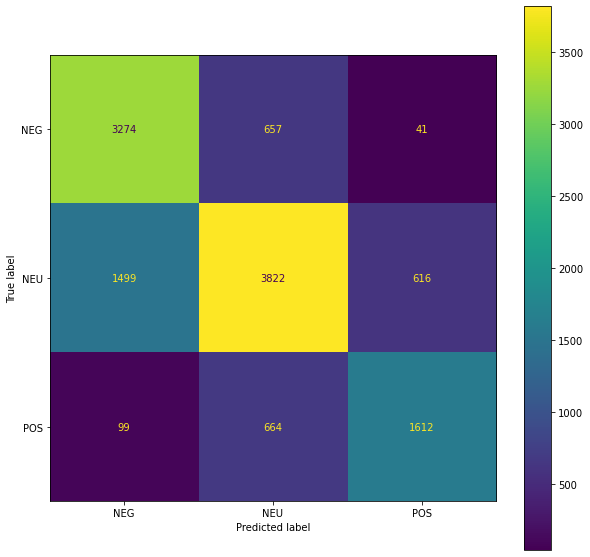

In [ ]:
text_file = open("tweeteval/datasets/sentiment/test_text.txt", "r")
label_file = open("tweeteval/datasets/sentiment/test_labels.txt", "r")

labels = []
predictions = []

label_dict = {'0': "NEG", '1': "NEU", '2': "POS"}

while True:
  line = text_file.readline()
  label = label_file.readline()
  if not line or not label: 
        break

  predictions.append(sentiment_analyzer.predict(line).output)
  labels.append(label_dict[label[0]])

text_file.close
label_file.close

cm = confusion_matrix(labels, predictions, labels=['NEG', 'NEU', 'POS'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['NEG', 'NEU', 'POS'])
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

In [ ]:
!git clone https://github.com/eusip/SILICONE-benchmark.git

Cloning into 'SILICONE-benchmark'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 84 (delta 27), reused 64 (delta 11), pack-reused 0
Unpacking objects: 100% (84/84), done.


In [ ]:
emotion_analyzer.predict("hey")

AnalyzerOutput(output=others, probas={others: 0.728, joy: 0.064, fear: 0.061, sadness: 0.053, anger: 0.034, disgust: 0.030, surprise: 0.030})

In [ ]:
text_file = "SILICONE-benchmark/dyda/test.csv"
df = pd.read_csv(text_file, delimiter=',')
df.head()

,Utterance,Dialogue_Act,Emotion,Dialogue_ID
0,"hey man , you wanna buy some weed ?",directive,no emotion,1
1,some what ?,question,surprise,1
2,"weed ! you know ? pot , ganja , mary jane some...",directive,no emotion,1
3,"oh , umm , no thanks .",commissive,no emotion,1
4,i also have blow if you prefer to do a few lin...,directive,no emotion,1


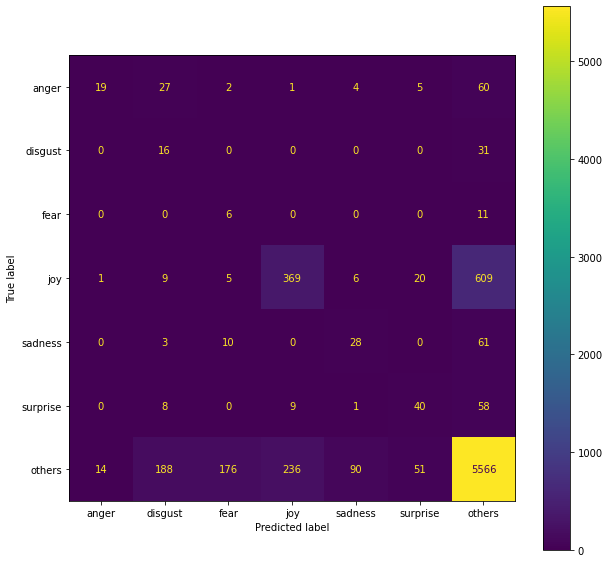

In [ ]:
labels = []
predictions = []


label_dict = {"anger": "anger", 
              "disgust": "disgust", 
              "fear": "fear", 
              "happiness": "joy", 
              "no emotion": "others", 
              "sadness": "sadness",
              "surprise": "surprise"}

for i, row in df.iterrows():
    predictions.append(emotion_analyzer.predict(row['Utterance']).output)
    labels.append(label_dict[row['Emotion']])


labels_name = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "others"]
cm = confusion_matrix(labels, predictions, labels=labels_name)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels_name)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

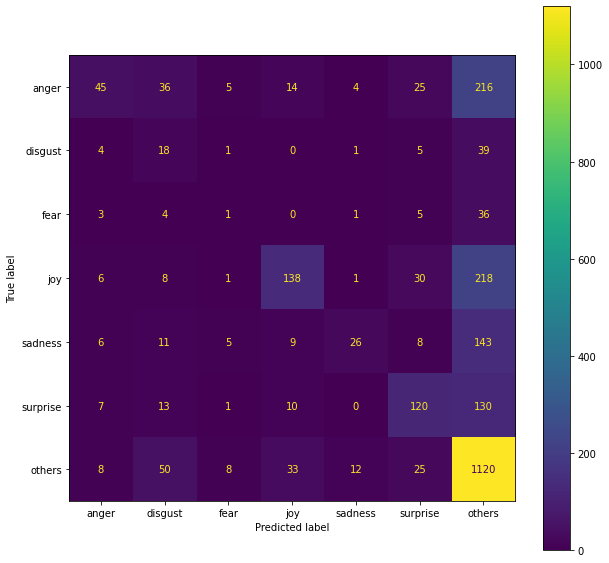

In [ ]:
text_file = "SILICONE-benchmark/meld/test.csv"
df = pd.read_csv(text_file, delimiter=',')
df.head()

emotion_labels = []
sentiment_labels = []
emotion_predictions = []
sentiment_predictions = []


emotion_label_dict = {"anger": "anger", 
              "disgust": "disgust", 
              "fear": "fear", 
              "joy": "joy", 
              "neutral": "others", 
              "sadness": "sadness",
              "surprise": "surprise"}
sentiment_label_dict = {
    "positive": "POS",
    "negative": "NEG",
    "neutral": "NEU"
}

for i, row in df.iterrows():
    emotion_predictions.append(emotion_analyzer.predict(row['Utterance']).output)
    emotion_labels.append(emotion_label_dict[row['Emotion']])

    sentiment_predictions.append(sentiment_analyzer.predict(row['Utterance']).output)
    sentiment_labels.append(sentiment_label_dict[row['Sentiment']])


labels_name = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "others"]
cm = confusion_matrix(emotion_labels, emotion_predictions, labels=labels_name)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels_name)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

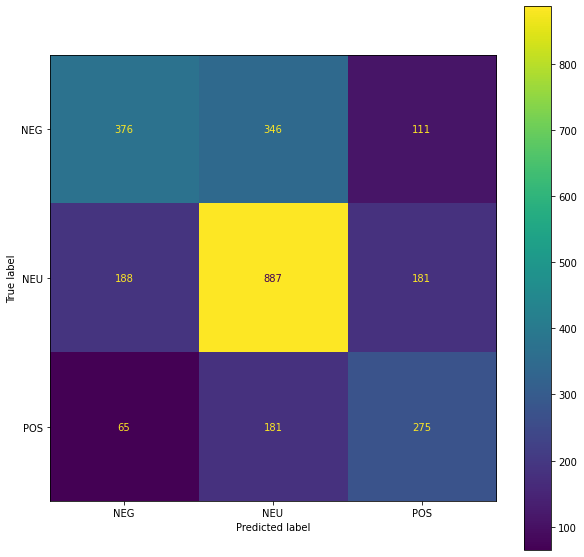

In [ ]:
cm = confusion_matrix(sentiment_labels, sentiment_predictions, 
                      labels=['NEG', 'NEU', 'POS'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['NEG', 'NEU', 'POS'])
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)
plt.show()

### Based on RoBERTa-large
https://huggingface.co/siebert/sentiment-roberta-large-english?text=I+like+you.+I+love+you

In [ ]:

!pip install transformers

     |████████████████████████████████| 3.5 MB 4.1 MB/s 
     |████████████████████████████████| 895 kB 48.7 MB/s 
     |████████████████████████████████| 6.5 MB 31.9 MB/s 
     |████████████████████████████████| 67 kB 5.5 MB/s 
     |████████████████████████████████| 596 kB 37.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer

# Create class for data preparation
class SimpleDataset:
    def __init__(self, tokenized_texts):
        self.tokenized_texts = tokenized_texts
    
    def __len__(self):
        return len(self.tokenized_texts["input_ids"])
    
    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.tokenized_texts.items()}
      
      
# Load tokenizer and model, create trainer
model_name = "siebert/sentiment-roberta-large-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
trainer = Trainer(model=model)

Downloading:   0%|          | 0.00/256 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/687 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/780k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32G [00:00<?, ?B/s]

In [ ]:
def run_predictions(pred_texts):
  # Tokenize texts and create prediction data set
  tokenized_texts = tokenizer(pred_texts,truncation=True,padding=True)
  pred_dataset = SimpleDataset(tokenized_texts)

  # Run predictions
  predictions = trainer.predict(pred_dataset)
  
  return predictions

In [ ]:
def create_df_from_preds(pred_texts, predictions, dialog_ind):
  # Transform predictions to labels
  preds = predictions.predictions.argmax(-1)
  labels = pd.Series(preds).map(model.config.id2label)
  scores = (np.exp(predictions[0])/np.exp(predictions[0]).sum(-1,keepdims=True)).max(1)
  indexes = [dialog_ind] * len(pred_texts)

  # Create DataFrame with texts, predictions, labels, and scores
  df = pd.DataFrame(list(zip(indexes, pred_texts,preds,labels,scores)), columns=['dialogue id', 'text','pred','label','score'])

  return df

In [ ]:
def markup_dialoguedatase(dialogue_dataset):
  all_df = pd.DataFrame()
  for dialogue in tqdm(dialogue_dataset):
    text = dialogue_as_list(dialogue)
    predictions = run_predictions(text)
    df = create_df_from_preds(text, predictions, dialogue.dialogue_id)
    all_df = pd.concat([all_df, df], ignore_index=True)
  return all_df

In [ ]:
#test_df = markup_dialoguedatase(test)


In [ ]:
#test_df.to_csv('sentiment_roberta_large_test.csv', index=False)

In [ ]:
val_df = markup_dialoguedatase(val)
val_df.to_csv('sentiment_roberta_large_val.csv', index=False)

  0%|          | 0/1000 [00:00<?, ?it/s]

***** Running Prediction *****
  Num examples = 12
  Batch size = 8


***** Running Prediction *****
  Num examples = 20
  Batch size = 8
***** Running Prediction *****
  Num examples = 6
  Batch size = 8
***** Running Prediction *****
  Num examples = 12
  Batch size = 8
***** Running Prediction *****
  Num examples = 20
  Batch size = 8
***** Running Prediction *****
  Num examples = 12
  Batch size = 8
***** Running Prediction *****
  Num examples = 16
  Batch size = 8
***** Running Prediction *****
  Num examples = 16
  Batch size = 8
***** Running Prediction *****
  Num examples = 28
  Batch size = 8
***** Running Prediction *****
  Num examples = 16
  Batch size = 8
***** Running Prediction *****
  Num examples = 26
  Batch size = 8
***** Running Prediction *****
  Num examples = 8
  Batch size = 8
***** Running Prediction *****
  Num examples = 18
  Batch size = 8
***** Running Prediction *****
  Num examples = 12
  Batch size = 8
***** Running Prediction *****
  Num examples = 18
  Batch size = 8
***** Running Prediction *****
  Num examples = 22